## Tweets Sentiment Analysis

### Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data Collection

In [3]:
df = pd.read_csv("..\\data\\raw\\1.6M_twitter.csv", encoding='latin1', header=None, names=['target', 'ids', 'date', 'flag', 'user', 'text'])
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Clustering

We will now cluster users based on the mean sentiment of all their tweets

In [4]:
df.drop(['ids', 'date', 'flag','text'], axis=1, inplace=True)
df['target'] = df['target'].map({0: -1, 4: 1})
df_mean = df.groupby('user').mean()

Example of a mostly negative twitter user:

In [5]:
df_mean.loc['webwoke']

target   -0.530435
Name: webwoke, dtype: float64

Example of a mostly positive twitter user:

In [6]:
df_mean.loc['VioletsCRUK']

target    0.562724
Name: VioletsCRUK, dtype: float64

In [7]:
means = df_mean.to_numpy()

We perform k-means clustering with 5 clusters:

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(means)
kmeans.labels_

c:\Users\ippok\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 2, 2, ..., 2, 1, 1])

In [9]:
kmeans.cluster_centers_

array([[ 4.35449388e-01],
       [-9.98389879e-01],
       [ 9.97736924e-01],
       [-1.87091997e-04],
       [-4.34152129e-01]])

We observe that the 5 centers roughly correspond to 5 user categories: 

1) very negative
2) very positive
3) neutral
4) negative
5) positive

In [10]:
df_clustered = pd.DataFrame(data=[df_mean.index, kmeans.labels_], index=['user','cluster'])

Let's take a look at the number of users belonging to each category:

In [11]:
df_clustered.iloc[1].value_counts().sort_index()

cluster
0     32693
1    285456
2    246999
3     59969
4     34658
Name: count, dtype: int64

Evaluation of our clustering algorithm, using the Davies-Bouldin cluster separation measure:

In [12]:
from sklearn import metrics

from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(means, kmeans.labels_)

0.2937582040358156

The closer this value is to 0, the better the clusters separation - 0.3 is a relatively good value.

### Data Cleaning

In [13]:
# Reload data
df = pd.read_csv("..\\data\\raw\\1.6M_twitter.csv", encoding='latin1', header=None, names=['target', 'ids', 'date', 'flag', 'user', 'text'])
df.drop(['ids', 'date', 'flag', 'user'], axis=1, inplace=True) # Drop the columns that are not needed
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [15]:
# Change the target to 0 and 1 for negative and positive
df['target'] = df['target'].map({0: 0, 4: 1})
df['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [16]:
df['text'] = df['text'].str.replace(r'@\w+', '', regex=True)  # Remove @mentions
df['text'] = df['text'].str.replace(r'https?://\S+', '', regex=True)  # Remove URLs
df['text'] = df['text'].str.replace('&quot;', '') # Remove &quot;
df['text'] = df['text'].str.replace('&lt;', ' ')  #remove &lt; (less than)
df['text'] = df['text'].str.replace('&gt;', ' ')  #remove &gt; (greater than)
df['text'] = df['text'].str.replace('--+', '', regex=True) # Remove multiple dashes
df['text'] = df['text'] = df['text'].str.replace('&amp;', 'and')  #replace &amp; with and
df['text'].str.strip()  # Remove leading/trailing whitespaces

0          - Awww, that's a bummer.  You shoulda got Davi...
1          is upset that he can't update his Facebook by ...
2          I dived many times for the ball. Managed to sa...
3             my whole body feels itchy and like its on fire
4          no, it's not behaving at all. i'm mad. why am ...
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999                                happy #charitytuesday
Name: text, Length: 1600000, dtype: object

In [17]:
df = df.drop_duplicates(subset=['text'], keep=False) # Drop duplicates

In [19]:
df_target_0 = df[df['target'] == 0].sample(n=50000, random_state=42) # Sample 50k from target 0
df_target_1 = df[df['target'] == 1].sample(n=50000, random_state=42) # Sample 50k from target 1

df_filtered = pd.concat([df_target_0, df_target_1]).reset_index(drop=True) # Concatenate the two dataframes

### Model

In [20]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_filtered, test_size=0.3, random_state=42) # Split the data into train and test
x_train, y_train = np.array(train_data['text']), np.array(train_data['target'])
x_test, y_test = np.array(test_data['text']), np.array(test_data['target'])

# Print the shapes of the data
print("Train data shape:", x_train.shape , y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

Train data shape: (70000,) (70000,)
Test data shape: (30000,) (30000,)


In [21]:
# Print the first data point
print(x_train[0], y_train[0])
print(x_test[0], y_test[0])

Mondays at the office   1
I didn't be all happy over yesterday's Soup. ...  I LOVE YOU.  1


In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')
vectorizer.fit(x_train) # Fit the vectorizer on the train data

# Transform the train and test data
x_train_vec = vectorizer.transform(x_train)
x_test_vec = vectorizer.transform(x_test)

print(x_train_vec.shape)
print(x_test_vec.shape)

(70000, 1000)
(30000, 1000)


In [29]:
import tensorflow as tf

# Create a simple neural network with 4 dense layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(x_train_vec.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(), # Batch normalization layer to normalize the activations of the previous layer
    tf.keras.layers.Dropout(rate=0.4), # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.8),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.8),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                64064     
                                                                 
 batch_normalization_12 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_13 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 128)              

In [30]:
model.fit(x_train_vec, y_train, epochs=10, batch_size=64)

Epoch 1/10
1094/1094 [==============================] - 12s 5ms/step - loss: 0.7463 - accuracy: 0.5036
Epoch 2/10
1094/1094 [==============================] - 6s 5ms/step - loss: 0.6613 - accuracy: 0.5933
Epoch 3/10
1094/1094 [==============================] - 6s 5ms/step - loss: 0.5799 - accuracy: 0.7017
Epoch 4/10
1094/1094 [==============================] - 6s 5ms/step - loss: 0.5570 - accuracy: 0.7217
Epoch 5/10
1094/1094 [==============================] - 6s 6ms/step - loss: 0.5458 - accuracy: 0.7271
Epoch 6/10
1094/1094 [==============================] - 6s 5ms/step - loss: 0.5396 - accuracy: 0.7302
Epoch 7/10
1094/1094 [==============================] - 5s 5ms/step - loss: 0.5332 - accuracy: 0.7361
Epoch 8/10
1094/1094 [==============================] - 6s 5ms/step - loss: 0.5238 - accuracy: 0.7433
Epoch 9/10
1094/1094 [==============================] - 5s 5ms/step - loss: 0.5167 - accuracy: 0.7479
Epoch 10/10
1094/1094 [==============================] - 7s 6ms/step - loss: 0.50

In [31]:
result = model.evaluate(x_test_vec, y_test)
loss = result[0]
accuracy = result[1]
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

938/938 [==============================] - 2s 2ms/step - loss: 0.5391 - accuracy: 0.7260
Test loss: 0.5390720367431641
Test accuracy: 0.7260333299636841


### Visualizations

In [32]:
from sklearn.metrics import classification_report

# Predict on the train data
y_pred = model.predict(x_train_vec)
y_pred_cont = model.predict(x_train_vec)
y_pred = np.round(y_pred)

print("Train Classification Report\n")
print(classification_report(y_train, y_pred, target_names=['Negative', 'Positive']))

2188/2188 [==============================] - 4s 2ms/step
Train Classification Report

              precision    recall  f1-score   support

    Negative       0.83      0.72      0.77     34945
    Positive       0.75      0.85      0.80     35055

    accuracy                           0.79     70000
   macro avg       0.79      0.79      0.78     70000
weighted avg       0.79      0.79      0.79     70000



In [33]:
# Predict on the test data
y_pred = model.predict(x_test_vec)
y_pred_cont = model.predict(x_test_vec)
y_pred = np.round(y_pred)

print("Test Classification Report\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

938/938 [==============================] - 2s 2ms/step
Test Classification Report

              precision    recall  f1-score   support

    Negative       0.77      0.65      0.71     15055
    Positive       0.70      0.80      0.74     14945

    accuracy                           0.73     30000
   macro avg       0.73      0.73      0.72     30000
weighted avg       0.73      0.73      0.72     30000



Figure(600x600)


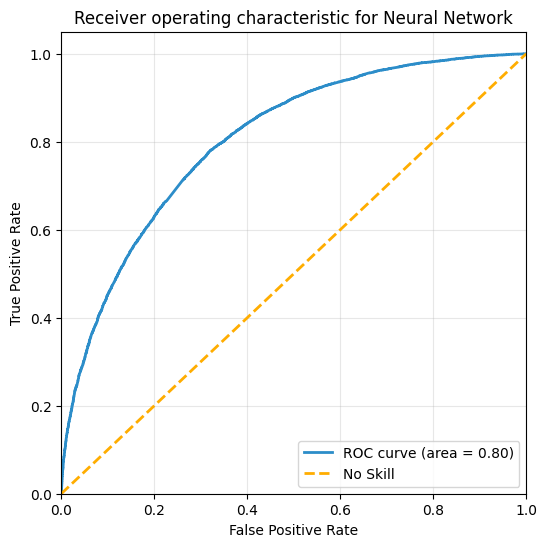

In [43]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

def roc_curve_plot(y_pred_cont, name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_cont)
    roc_auc = auc(fpr, tpr)

    figure, axis = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
    axis.plot(fpr, tpr, color='#2c8dc9', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axis.plot([0, 1], [0, 1], color='#FFAD00', lw=2, linestyle='--', label='No Skill')
    axis.set_xlim([0.0, 1.0])
    axis.set_ylim([0.0, 1.05])
    axis.set_xlabel('False Positive Rate')
    axis.set_ylabel('True Positive Rate')
    axis.set_title('Receiver operating characteristic for {estimator}'.format(estimator=name))
    axis.legend(loc="lower right")
    axis.grid(alpha=0.3)

    return figure

print(roc_curve_plot(y_pred_cont, 'Neural Network'))

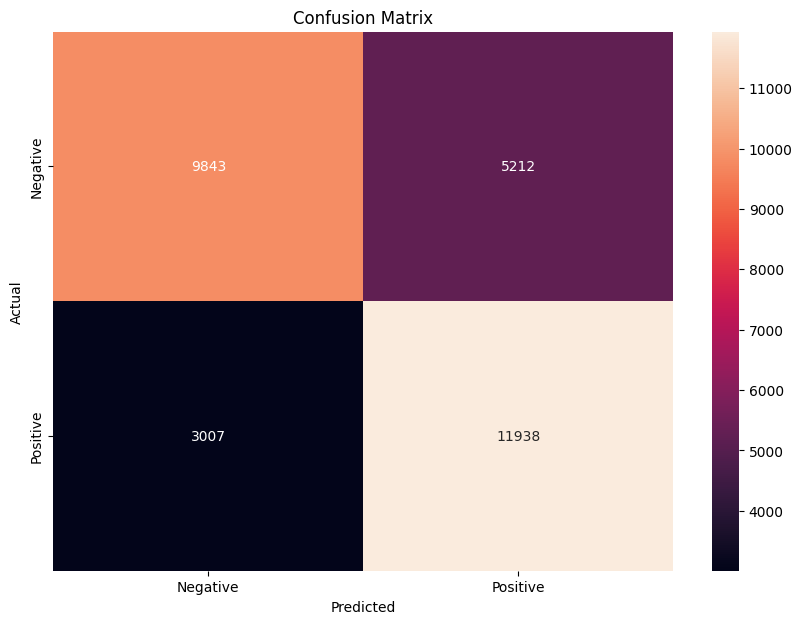

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])

plt.figure(figsize=(10,7))

# Create a heatmap from the DataFrame
sns.heatmap(cm_df, annot=True, fmt='g')

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()